# ChatBot Model

## Import libraries

We import 4 main library categories:
- Natural Language Processing (nltk)
- Deep Learning (tensorflow, keras, sklearn)
- Plotting (matplotlib, IPython)
- Misc (numpy, random, json)

In [1]:
# NLP libraries
import nltk
nltk.download('punkt')
from nltk.stem.snowball import ItalianStemmer

# deep learning libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import utils
from keras import layers
from keras.models import load_model
from sklearn.model_selection import train_test_split

# plot libraries
import matplotlib.pyplot as plt
import IPython
from IPython.display import clear_output
import tabulate
from prettytable import PrettyTable

# other libraries
import numpy as np
import random
import json
from decimal import Decimal

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Erik.Bessegato\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


## Import intents

All the intents are stored in a intents.json file. 
Each intent has 3 attributes:
- tag: the class 
- patterns: all the sentences belonging to that class
- responses: all the responses related to that class

In [3]:
# import our chat-bot intents file
with open('gathered_tickets.json',encoding='UTF-8') as json_data:
    intents = json.load(json_data, strict=False)
    
with open('ml_features.json',encoding='UTF-8') as json_data2:
    features = json.load(json_data2, strict=False)

## Class to plot the data

This class will be used to plot the data during the training phase of the neural network.

For documentation, see https://keras.io/callbacks/

In [4]:
# class to create a training-validation plot 
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

## Organize the Training data

The stemmer will extract a stem for each token (word) of each input pattern (sentence).


In [5]:
# create an Italian language stemmer
stemmer = ItalianStemmer()

# array to store stemmed words 
words = []

# array to store the classes
classes = []

# array to store documents. A document is a couple composed by the tokenized sentence and its category
documents = []

# words ignored by the parser
ignore_words = ['a','adesso','ai','al','alla','allo','allora','altre','altri','altro','anche','ancora','avere','aveva',
                'avevano','ben','buono','che','chi','cinque','comprare','con','consecutivi','consecutivo','cosa','cui',
                'da','del','della','dello','dentro','deve','devo','di','doppio','due','e','ecco','fare','fine','fino',
                'fra','gente','giu','ha','hai','hanno','ho','il','indietro','invece','io','la','lavoro','le','lei','lo',
                'loro','lui','lungo','ma','me','meglio','molta','molti','molto','nei','nella','no','noi','nome',
                'nostro','nove','nuovi','nuovo','o','oltre','ora','otto','peggio','pero','persone','piu','poco','primo',
                'promesso','qua','quarto','quasi','quattro','quello','questo','qui','quindi','quinto','rispetto','sara',
                'secondo','sei','sembra','senza','sette','sia','siamo','siete','solo','sono','sopra','soprattutto',
                'sotto','stati','stato','stesso','su','subito','sul','sulla','tanto','te','tempo','terzo','tra','tre',
                'triplo','ultimo','un','una','uno','va','vai','voi','volte','vostro']
      
# loop through each sentence in the intents patterns to create bag of words
for intent in features['intents']:
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # add to the words list
        words.extend(w)
        
        # add to the classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])    

# loop through each sentence in the intents patterns to create documents
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # add to documents in the corpus
        documents.append((w, intent['tag']))
        

# stem and lower each word and remove duplicates
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

unique_stemmed_words = len(words)

# remove duplicates
classes = sorted(list(set(classes)))

# export arrays as csv files
#np.savetxt("problem_words.csv", words, delimiter=",",fmt='%s')
#np.savetxt("problem_classes.csv", classes, delimiter=",",fmt='%s')
#np.savetxt("problem_documents.csv", documents, delimiter=",",fmt='%s')

# create the training data
training = []
output = []

# create an empty array for the output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # stem each word
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # create the bag of words array
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    # output is a '0' for each tag and '1' for current tag
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

print (len(documents), "documents")
print (len(classes), "classes", classes)
print (len(words), "unique stemmed words", words)
# print (documents)

209 documents
12 classes ['HW - Accessori', 'HW - PC', 'HW - Rete', 'SW - Altri Software', 'SW - Internet', 'SW - Mago', 'SW - Office', 'SW - SVN', 'SW - Server', 'SW - Sistema Operativo', 'SW - VPN', 'noanswer']
147 unique stemmed words ['10', '192.168.0.230', '192.168.0.236', '365', '7', '7zip', '8.1', 'abilit', 'access', 'accessor', 'account', 'acrobat', 'adatt', 'adob', 'aggiorn', 'aggiung', 'aliment', 'alzatin', 'ampdevserver', 'android', 'anomal', 'antivirus', 'archiv', 'aziendal', 'bluetooth', 'calendar', 'camb', 'cartell', 'casell', 'cav', 'cell', 'cellul', 'cod', 'commess', 'commit', 'computer', 'configur', 'connession', 'connett', 'credenzial', 'cuff', 'disk', 'dns', 'document', 'domin', 'driv', 'e-mail', 'eclips', 'elenc', 'email', 'ethernet', 'excel', 'exchang', 'firewall', 'formazion', 'forticlient', 'framework', 'guast', 'hard', 'hd', 'hdd', 'hdmi', 'hub', 'ide', 'indirizz', 'integr', 'ip', 'jav', 'laptop', 'lent', 'licenz', 'login', 'mac', 'macchin', 'mag', 'mail', 'memo

## Divide the input dataset in training and validation datasets

In [6]:
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)

# create train and test lists
data_x = list(training[:,0])
data_y = list(training[:,1])

# split the dataset in training set and validation set
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=42)

## Design, build and train the Neural Network

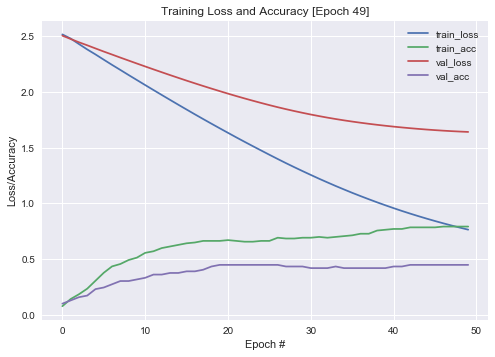

In [9]:
# design the model
model = Sequential()
model.add(Dense(unique_stemmed_words, input_shape=[len(data_x[0],)]))
model.add(Dense(unique_stemmed_words//2))
#model.add(Dense(unique_stemmed_words//3))
model.add(Dense(len(data_y[0]), activation='softmax'))

# print a summary about the model
model.summary()

# configure the model for training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# train the model
# set epochs to avoid overfitting
# delete callbacks=[plot_losses] for fast training and no graph
history = model.fit(np.array(x_train), 
                    np.array(y_train), 
                    epochs=50, 
                    batch_size=500,
                    validation_data=(np.array(x_test), np.array(y_test)),
                    callbacks=[plot_losses])
                    #validation_data=(np.array(x_test), np.array(y_test)))


## Export the trained model

In [45]:
model.save('problem_model.h5')

## Reply to a sentence

In [46]:
def stem_and_tokenize_sentence(sentence):
    # tokenize the pattern
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=False):
    # tokenize the pattern
    sentence_words = stem_and_tokenize_sentence(sentence)
    # bag of words
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)

    return(np.array(bag))

# set the threshold above which a classification will be considered correct
ERROR_THRESHOLD = 0.65

# classify a new sentence in a category
def classify(sentence):
    # generate probabilities from the model
    bag_of_words = bow(sentence, words)
        
    bow_capacity = len(bag_of_words)
    doc_capacity = len(documents)-2
    zero_matrix = np.zeros([doc_capacity, bow_capacity])
    dl_input = np.vstack((bag_of_words,zero_matrix))
    
    results = model.predict(dl_input)[0]
    
    results_test = model.predict(dl_input)
        
    # interface      
    t = PrettyTable(['Class', 'Result'])
    for i in range(len(classes)):
            t.add_row([classes[i],round(results[i],2)])
    print (t)
    
    problem_no_answer_index = [i for i,x in enumerate(classes) if x == "noanswer"]
    
    # filter out predictions below a threshold
    # 7 is the index of 'no answer' class 
    results = [[i,r] for i,r in enumerate(results) if ((r > ERROR_THRESHOLD)  or (i == problem_no_answer_index)) ]
    
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append((classes[r[0]], r[1]))
    
    print('Result:',return_list)
    
    # return tuple of intent and probability
    return return_list

## Interface to test the Neural Network

In [47]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

from IPython.display import HTML, display


def f(x):
    return classify(x)

int_widget = interactive(f, x='Non funziona il computer')
int_widget.children[0].layout = Layout(width='900px')
int_widget

interactive(children=(Text(value='Non funziona il computer', description='x', layout=Layout(width='900px')), O…